In [1]:
import sys

sys.path.append("../")

## random walk

In [2]:
import json
import os
from pprint import pprint

from src.graph import TYPES_OF_GRAPH, Graph
from src.sample_dialogue import sample_dialogue

path = '../data'

input_path = os.path.join(path, 'theme_graph.json')
graph_dict = json.load(open(input_path, 'r'))
graph = Graph(graph_dict, TYPES_OF_GRAPH.DI)

sampled_dialogue, sampled_base_graph = sample_dialogue(
    graph.nx_graph,
    start_node=1,
    topic='books'
)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
False


In [3]:
pprint(sampled_base_graph)

{'edges': [{'source': 1,
            'target': 2,
            'theme': 'books',
            'utterances': ['I want to read something.']},
           {'source': 2,
            'target': 4,
            'theme': 'books',
            'utterances': ['I prefer non-fiction.']},
           {'source': 4,
            'target': 5,
            'theme': 'books',
            'utterances': ['I enjoy biographies.']},
           {'source': 5,
            'target': 6,
            'theme': 'books',
            'utterances': ['What are the popular books in this genre?']},
           {'source': 6,
            'target': 7,
            'theme': 'books',
            'utterances': ['Any recommendations for authors?']},
           {'source': 7,
            'target': 8,
            'theme': 'books',
            'utterances': ['I never heard about this author, but ihe seems '
                           'interesting']},
           {'source': 8,
            'target': 9,
            'theme': 'books',
            'ut

In [4]:
pprint(sampled_dialogue)

[{'participant': 'assistant',
  'text': 'I am ready to help you choose a book, a movie, or a game.'},
 {'participant': 'user',
  'source': 1,
  'target': 2,
  'text': 'I want to read something.'},
 {'participant': 'assistant',
  'text': 'Would you like a fiction or a non-fiction book?'},
 {'participant': 'user',
  'source': 2,
  'target': 4,
  'text': 'I prefer non-fiction.'},
 {'participant': 'assistant',
  'text': 'What genres of non-fiction are you interested in?'},
 {'participant': 'user',
  'source': 4,
  'target': 5,
  'text': 'I enjoy biographies.'},
 {'participant': 'assistant', 'text': 'Bestsellers or something specific?'},
 {'participant': 'user',
  'source': 5,
  'target': 6,
  'text': 'What are the popular books in this genre?'},
 {'participant': 'assistant',
  'text': 'Sure, this is top-5 books of chose genre'},
 {'participant': 'user',
  'source': 6,
  'target': 7,
  'text': 'Any recommendations for authors?'},
 {'participant': 'assistant', 'text': 'Do you have any favori

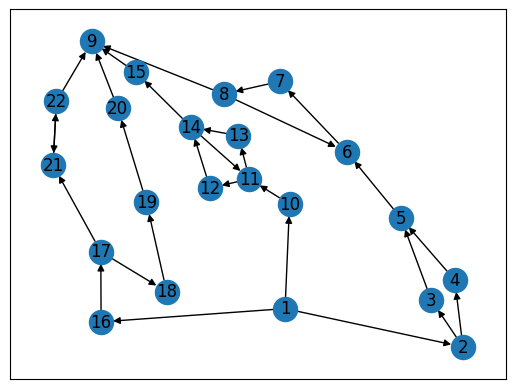

In [5]:
import networkx as nx

nx.draw_networkx(graph.nx_graph)

## all simple paths

In [6]:
paths_generator = nx.all_simple_edge_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)

In [7]:
paths

[[(1, 2), (2, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 2), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 10), (10, 11), (11, 12), (12, 14), (14, 15), (15, 9)],
 [(1, 10), (10, 11), (11, 13), (13, 14), (14, 15), (15, 9)],
 [(1, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 9)],
 [(1, 16), (16, 17), (17, 21), (21, 22), (22, 9)]]

In [8]:
from src.sample_dialogue import materialize_dialogue

pprint(materialize_dialogue(graph.nx_graph, paths[-1]))

[{'participant': 'assistant', 'text': 'How can I help?'},
 {'participant': 'user', 'text': 'I want to play a game.'},
 {'participant': 'assistant',
  'text': "You're looking for a video game recommendation."},
 {'participant': 'user', 'text': 'What kind of games do you like?'},
 {'participant': 'assistant', 'text': 'Which genre of games do you prefer?'},
 {'participant': 'user', 'text': 'Tell me about the reviews for this game.'},
 {'participant': 'assistant',
  'text': 'What are the reviews like for this game?'},
 {'participant': 'user', 'text': 'What are the features of this game?'},
 {'participant': 'assistant',
  'text': "I'd like to know about the features of this game."},
 {'participant': 'user', 'text': "I'll definitely play this one."},
 {'participant': 'assistant', 'text': 'I am sure you will like it'}]


## add cycles

In [9]:
all_cycles = nx.recursive_simple_cycles(graph.nx_graph)
all_cycles

[[6, 7, 8], [11, 12, 14], [11, 13, 14], [21, 22]]

In [10]:
paths_generator = nx.all_simple_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

[[1, 2, 3, 5, 6, 7, 8, 9],
 [1, 2, 4, 5, 6, 7, 8, 9],
 [1, 10, 11, 12, 14, 15, 9],
 [1, 10, 11, 13, 14, 15, 9],
 [1, 16, 17, 18, 19, 20, 9],
 [1, 16, 17, 21, 22, 9]]

In [11]:
from src.dialogue_sampling.cycles import add_cycles


add_cycles(graph.nx_graph, paths[5], n_cycles=1, n_repeats=[1])

[1, 16, 17, 21, 22, 21, 22, 9]

## topics

In [12]:
paths_generator = nx.all_simple_edge_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

[[(1, 2), (2, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 2), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 10), (10, 11), (11, 12), (12, 14), (14, 15), (15, 9)],
 [(1, 10), (10, 11), (11, 13), (13, 14), (14, 15), (15, 9)],
 [(1, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 9)],
 [(1, 16), (16, 17), (17, 21), (21, 22), (22, 9)]]

In [13]:
from src.dialogue_sampling.topics import get_topics

for p in paths:
    print(get_topics(graph.nx_graph, p))

{'books'}
{'books'}
{'movies'}
{'movies'}
{'videogames'}
{'videogames'}


## degree of uniqueness

In [14]:
paths_generator = nx.all_simple_edge_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

[[(1, 2), (2, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 2), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 10), (10, 11), (11, 12), (12, 14), (14, 15), (15, 9)],
 [(1, 10), (10, 11), (11, 13), (13, 14), (14, 15), (15, 9)],
 [(1, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 9)],
 [(1, 16), (16, 17), (17, 21), (21, 22), (22, 9)]]

In [15]:
from src.dialogue_sampling.utterance import materialize_dialogue

In [16]:
materialize_dialogue(graph.nx_graph, paths[0], alpha=1.)

[{'text': 'Do you want to choose a book, a movie, or a game?',
  'participant': 'assistant'},
 {'text': 'I need a book.', 'participant': 'user'},
 {'text': 'How about something from the fiction genre?',
  'participant': 'assistant'},
 {'text': 'I want to read fiction.', 'participant': 'user'},
 {'text': 'Do you have a specific genre of fiction in mind?',
  'participant': 'assistant'},
 {'text': 'I like fantasy.', 'participant': 'user'},
 {'text': 'Bestsellers or something specific?', 'participant': 'assistant'},
 {'text': 'Show me the bestsellers.', 'participant': 'user'},
 {'text': 'These are some highly recommended books.',
  'participant': 'assistant'},
 {'text': 'Who are the famous authors in this genre?', 'participant': 'user'},
 {'text': 'Which authors do you prefer?', 'participant': 'assistant'},
 {'text': 'I never heard about this author, but ihe seems interesting',
  'participant': 'user'},
 {'text': "Shall I provide more information about this author' book?",
  'participant':

In [17]:
graph.nx_graph.edges[1,2]

{'theme': 'books',
 'utterances': ['I want to read something.',
  'I need a book.',
  'Can you recommend a book?']}

In [18]:
from src.dialogue_sampling.cycles import add_cycles

paths_generator = nx.all_simple_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

cycled_path = add_cycles(graph.nx_graph, paths[0], n_cycles=1, n_repeats=[5])
cycled_path

[1, 2, 3, 5, 6, 7, 8, 6, 7, 8, 6, 7, 8, 6, 7, 8, 6, 7, 8, 6, 7, 8, 9]

In [19]:
def node_path_to_edge_path(path: list[int]) -> list[tuple[int,int]]:
    res = []
    for i in range(len(path)-1):
        res.append((path[i], path[i+1]))
    return res

In [20]:
materialize_dialogue(graph.nx_graph, node_path_to_edge_path(cycled_path), alpha=0)

[{'text': 'I am ready to help you choose a book, a movie, or a game.',
  'participant': 'assistant'},
 {'text': 'Can you recommend a book?', 'participant': 'user'},
 {'text': 'Are you interested in fiction or non-fiction?',
  'participant': 'assistant'},
 {'text': "I'm interested in fiction.", 'participant': 'user'},
 {'text': 'What genres of fiction are you interested in?',
  'participant': 'assistant'},
 {'text': 'I like fantasy.', 'participant': 'user'},
 {'text': 'Do you want to check out popular books.',
  'participant': 'assistant'},
 {'text': 'Show me the bestsellers.', 'participant': 'user'},
 {'text': 'These are some highly recommended books.',
  'participant': 'assistant'},
 {'text': 'Suggest some authors I should read.', 'participant': 'user'},
 {'text': 'Are there any authors you like?', 'participant': 'assistant'},
 {'text': 'I like this author', 'participant': 'user'},
 {'text': "Do you want to know more about this author' books?",
  'participant': 'assistant'},
 {'text':

In [21]:
materialize_dialogue(graph.nx_graph, node_path_to_edge_path(cycled_path), alpha=1.)

[{'text': 'Do you want to choose a book, a movie, or a game?',
  'participant': 'assistant'},
 {'text': 'Can you recommend a book?', 'participant': 'user'},
 {'text': 'Would you like a fiction or a non-fiction book?',
  'participant': 'assistant'},
 {'text': 'I want to read fiction.', 'participant': 'user'},
 {'text': 'Which genre of fiction do you prefer?', 'participant': 'assistant'},
 {'text': 'Do you have any mystery novels?', 'participant': 'user'},
 {'text': 'Bestsellers or something specific?', 'participant': 'assistant'},
 {'text': 'Show me the bestsellers.', 'participant': 'user'},
 {'text': 'Check out these popular books.', 'participant': 'assistant'},
 {'text': 'Suggest some authors I should read.', 'participant': 'user'},
 {'text': 'Which authors do you prefer?', 'participant': 'assistant'},
 {'text': 'Give me the details of this authour.', 'participant': 'user'},
 {'text': "Would you like more details about this author' books?",
  'participant': 'assistant'},
 {'text': 'No

## constructive sampling

In [22]:
import json
import os

from src.graph import TYPES_OF_GRAPH, Graph

path = '../data'

input_path = os.path.join(path, 'theme_graph.json')
graph_dict = json.load(open(input_path, 'r'))
graph = Graph(graph_dict, TYPES_OF_GRAPH.DI)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
False


In [23]:
from src.dialogue_sampling import sample_dialogues

sample_dialogues(
    graph=graph.nx_graph,
    start_node=1,
    terminal_node=9,
    topics=['videogames'],
    n_cycles=1,
    n_repeats=[1],
    uniqueness=10.
)

[[{'text': 'How can I help?', 'participant': 'assistant'},
  {'text': 'Can you recommend a video game?', 'participant': 'user'},
  {'text': "You're looking for a video game recommendation.",
   'participant': 'assistant'},
  {'text': 'Recommend me a genre of game.', 'participant': 'user'},
  {'text': 'Do you have a specific game genre in mind?',
   'participant': 'assistant'},
  {'text': 'Show me the popular games.', 'participant': 'user'},
  {'text': 'These are some highly recommended games.',
   'participant': 'assistant'},
  {'text': 'Recommend me games from my favorite developers.',
   'participant': 'user'},
  {'text': 'Are there any game developers you like?',
   'participant': 'assistant'},
  {'text': 'Give me the details of this game.', 'participant': 'user'},
  {'text': 'Do you want to know more about this game?',
   'participant': 'assistant'},
  {'text': 'Thanks for the recommendation!', 'participant': 'user'},
  {'text': 'It seems like a great choice for you.',
   'particip